In [1]:
import pandas as pd
from scripts.hn_scrape import main
from scripts.metafilter_scrape import scrape_metafilter
from utils.initial_eda import initial_eda, save_eda_report

In [2]:
hn_main = pd.read_csv("hn_posts.csv", parse_dates=['created_at'])
hn_comments = pd.read_csv("hn_comments.csv", parse_dates=['datetime_obj'])

hn_comments.drop(columns='day_of_week', inplace=True)

hn_main.rename(columns={"story_id": "post_id", "author": "post_author"}, inplace=True)
hn_comments.rename(columns={"story_id": "post_id", "user": "username", "datetime_obj": "created_at"}, inplace=True)

,Value
Posts,15
Comments,1303
Unique Post Authors,15
Unique Commenters,674
Date Range,2026-01-14 to 2026-01-29


,Comments Per Post
count,15.000000
mean,86.866667
std,84.299523
min,14.000000
25%,25.500000
50%,47.000000
75%,105.500000
max,295.000000


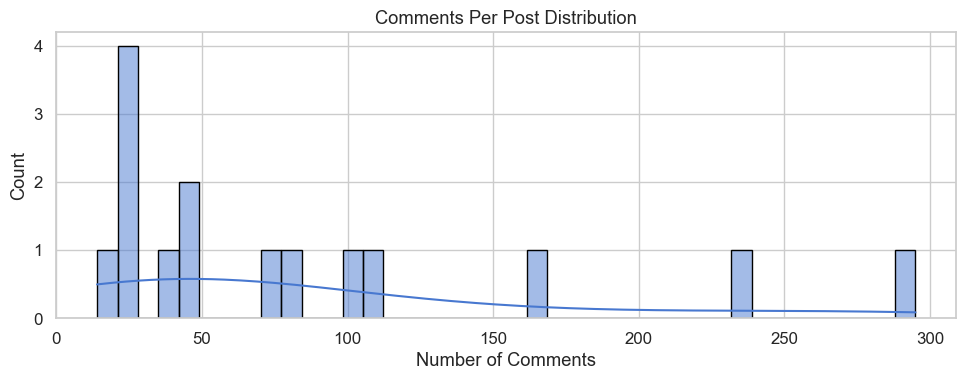

Computing text statistics: 100%|██████████| 1303/1303 [00:01<00:00, 765.52it/s] 


,mean,median,std,min,max
char_length,358.48,252.00,373.79,3.0,3909.0
word_count,58.61,42.00,60.35,1.0,590.0
sentence_count,3.50,3.00,3.16,1.0,32.0
avg_word_length,6.57,6.04,3.84,3.0,77.0
syllable_count,94.49,67.00,98.34,2.0,1015.0
lexicon_count,58.34,42.00,60.12,1.0,584.0
polysyllable_count,9.23,6.00,10.11,0.0,97.0
monosyllable_count,37.13,27.00,37.92,0.0,348.0


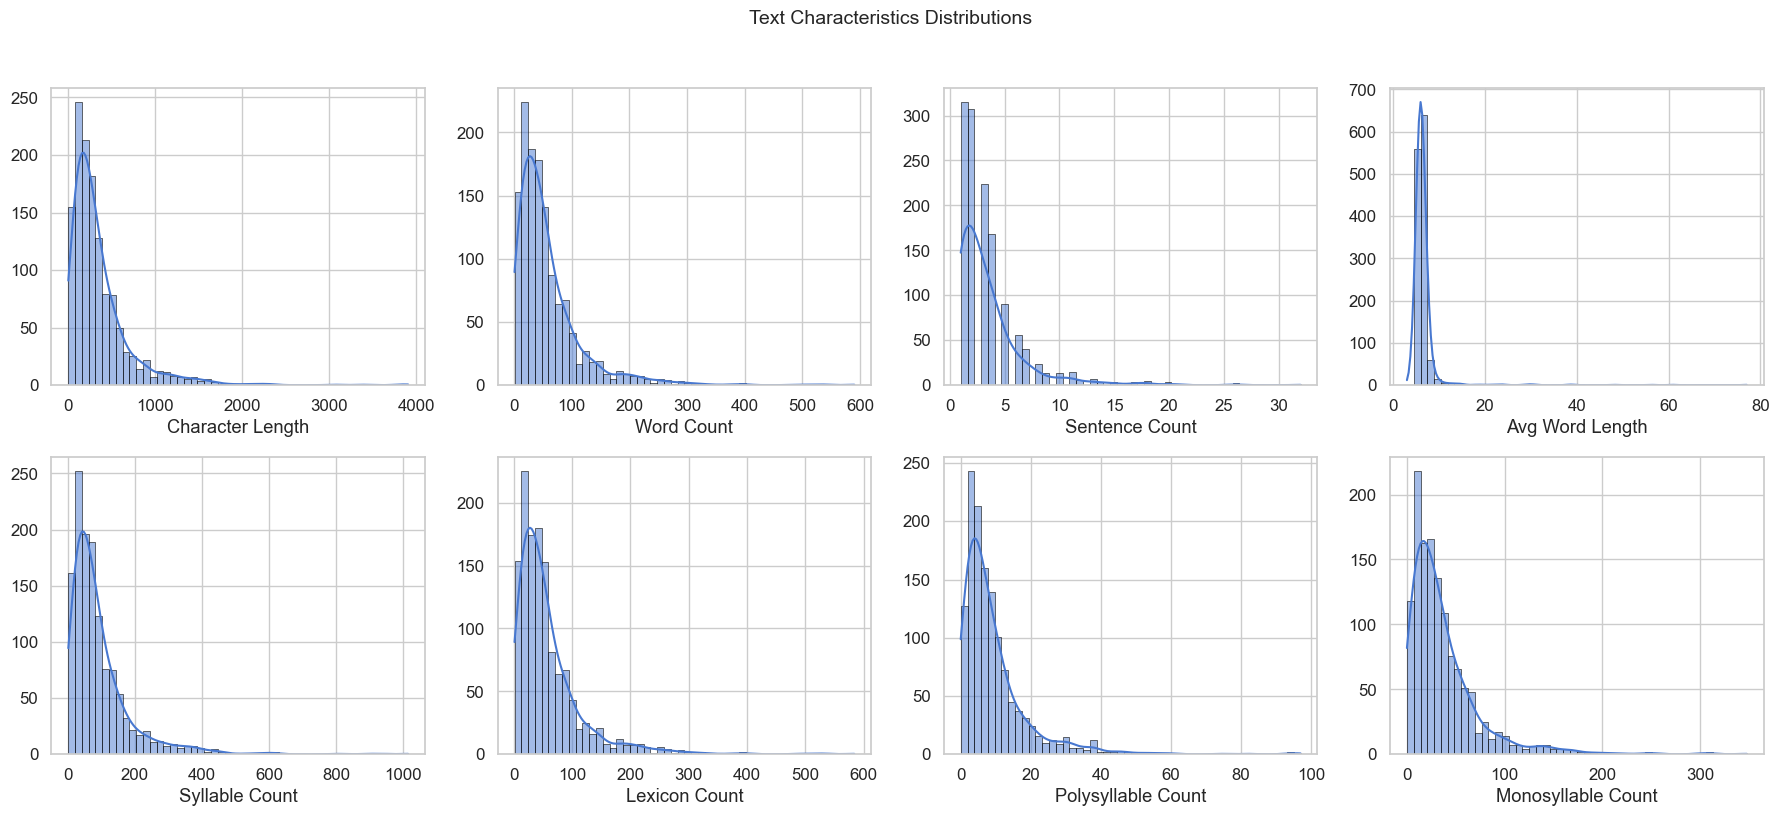

,mean,median,std,min,max
flesch_reading_ease,46.91,52.26,45.82,-809.38,103.70
dale_chall,8.75,8.58,1.90,3.74,19.53
grade_level,11.31,10.00,10.19,0.00,320.00
gunning_fog,12.88,12.27,4.94,0.40,41.78


Metric,Scale Interpretation
Flesch Reading Ease,0-30 Very Difficult | 30-50 Difficult | 50-60 Fairly Difficult | 60-70 Standard | 70-80 Fairly Easy | 80-90 Easy | 90+ Very Easy
Dale-Chall,4.9 or lower = Grade 4 | 5.0-5.9 = Grades 5-6 | 6.0-6.9 = Grades 7-8 | 7.0-7.9 = Grades 9-10 | 8.0-8.9 = Grades 11-12 | 9.0+ = College
Grade Level,Consensus US grade level (average of multiple formulas)
Gunning Fog,6 = Easy | 8 = Average | 12 = High school senior | 17+ = College graduate


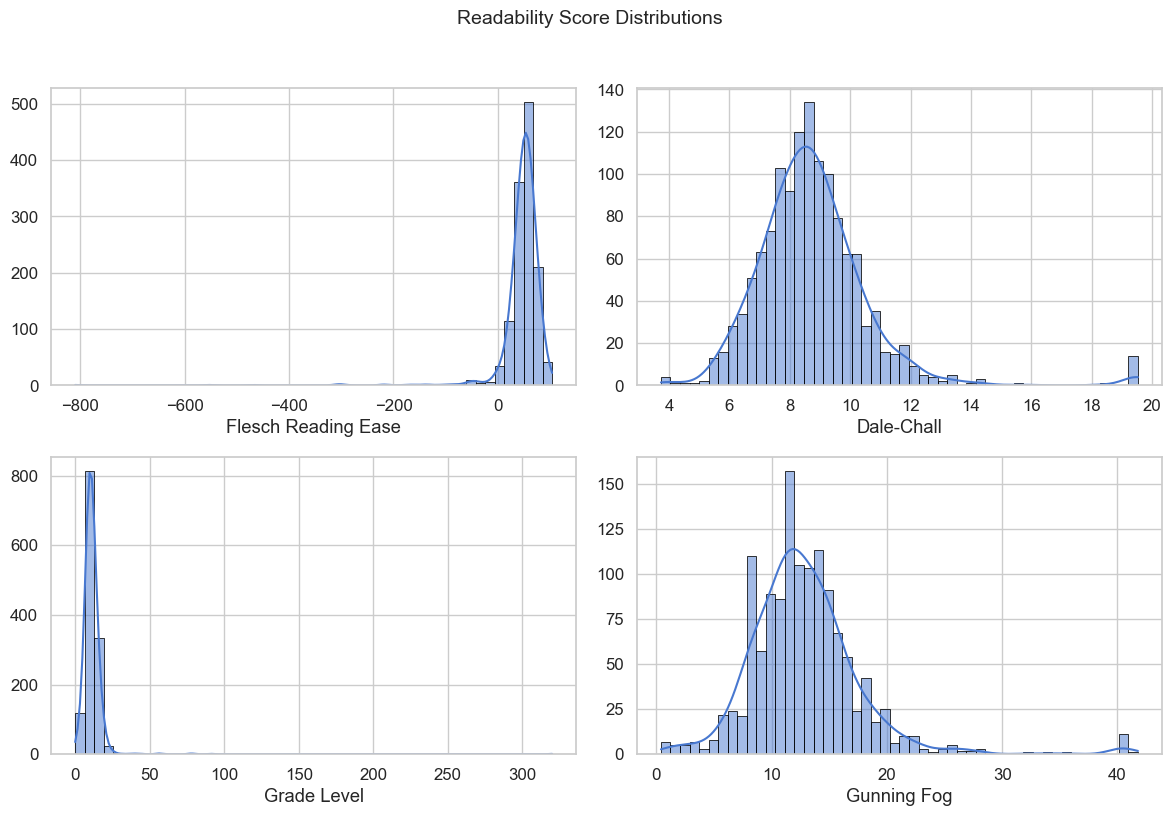

Detecting features: 100%|██████████| 1303/1303 [00:00<00:00, 64014.55it/s]


,% Comments With,Avg Count (when present)
Feature,,
Mentions (@),0.2%,1.00
URLs,9.4%,1.19
Hashtags (#),0.5%,1.17
Emojis,0.0%,N/A


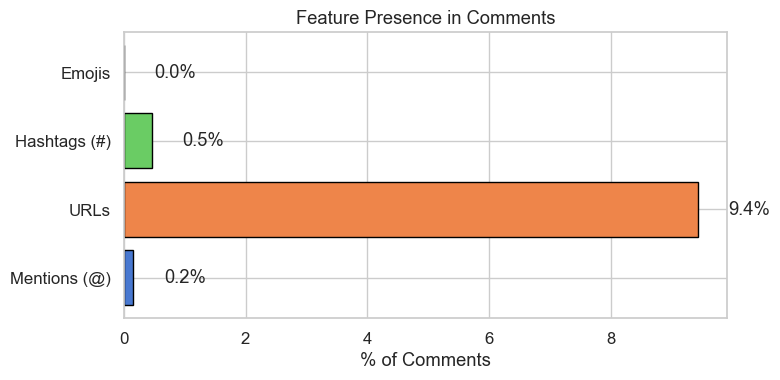

Computing VADER sentiment: 100%|██████████| 1303/1303 [00:00<00:00, 2131.26it/s]


,Count,Percentage
vader_label,,
positive,576,44.2%
negative,537,41.2%
neutral,190,14.6%


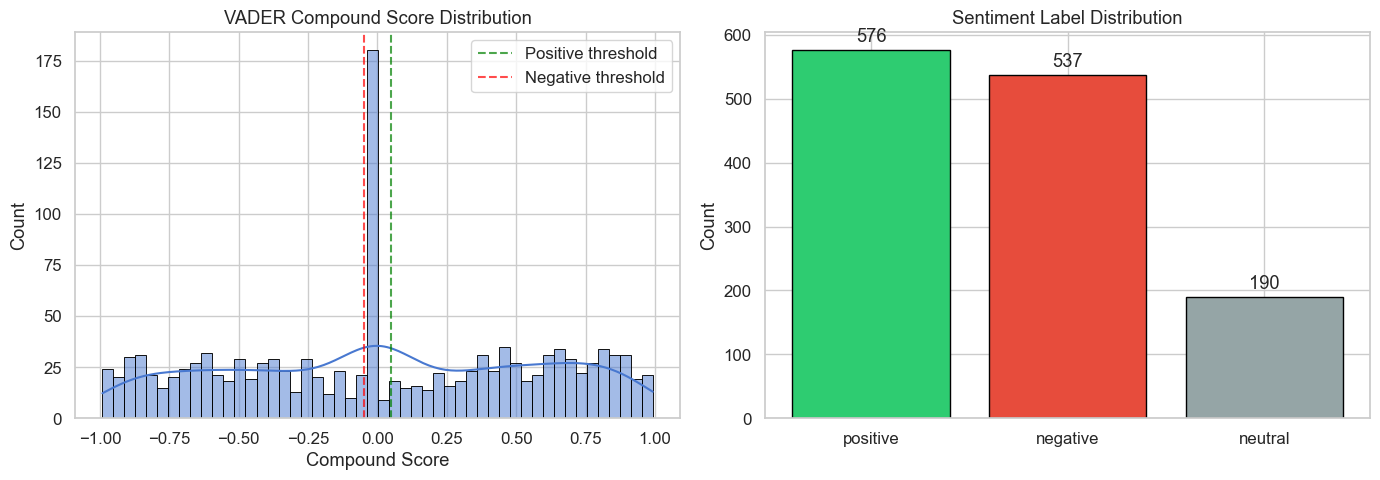

,comment_text,vader_compound
0,I completely agree. I let LLMs write a ton of ...,0.9921
1,I agree that there is no 4d chess here but I d...,0.9908
2,I think you're correct that independents are b...,0.9899
3,"Oh, I am talking about democracies and lecturi...",0.9874
4,Agreed. Humans are insanely good at figuring o...,0.9857


,comment_text,vader_compound
0,"But what if these ""local conditions"" are the a...",-0.9911
1,"You're using ""false equivalence"" bias. Not eve...",-0.9892
2,That is a strange interpretation.According to ...,-0.9878
3,All you are describing is a restructuring of w...,-0.9867
4,>> But Maduro isn't exactly Mohammed bin Salma...,-0.9856


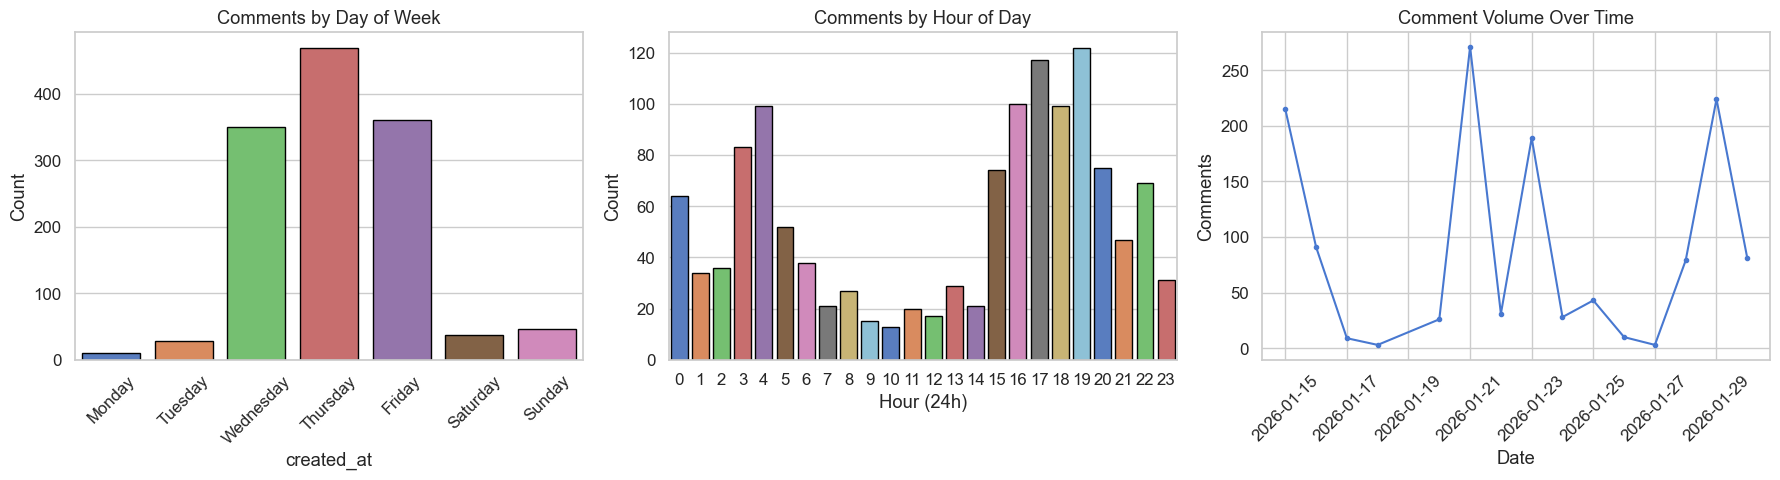

,n_comments,unique_commenters,comment_commenter_ratio
count,15.00,15.00,15.00
mean,86.87,50.00,1.67
std,84.30,46.49,0.35
min,14.00,10.00,1.31
25%,25.50,18.00,1.40
50%,47.00,34.00,1.53
75%,105.50,62.00,2.02
max,295.00,168.00,2.32


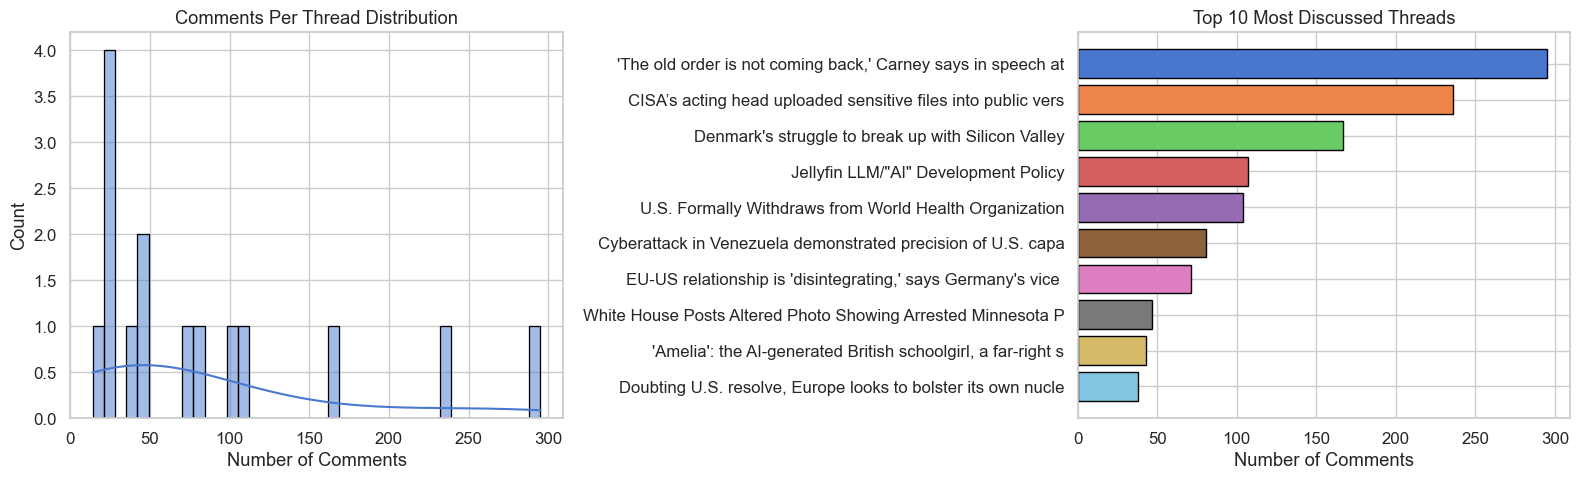

Computing POS tag ratios: 100%|██████████| 1303/1303 [00:03<00:00, 384.55it/s]


,mean,median,std
Adjectives (JJ*),0.0880,0.0837,0.0533
Adverbs (RB*),0.0698,0.0667,0.0528
Pronouns (PRP*),0.0706,0.0667,0.0504
Modals (MD),0.0162,0.0000,0.0238
Interjections (UH),0.0008,0.0000,0.0074


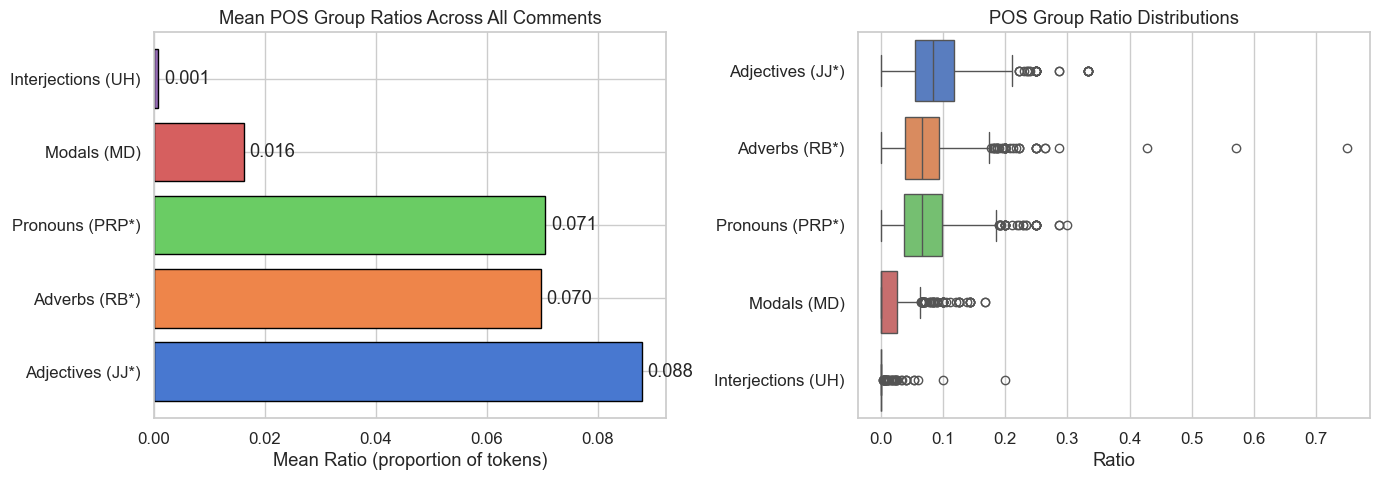

In [3]:
report = initial_eda(main=hn_main, comments=hn_comments, source='Hacker News')